<a href="https://colab.research.google.com/github/P-jinwan/Dacon/blob/master/fashion_MNIST%EF%BC%9Aclothing_class_prediction(corab_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Fashion MNIST : 의류 클래스 예측
이미지를 분석하여 의류 클래스를 분류 해보세요.
### 1. train.csv / test.csv
- index: index
- label: 의류의 범주(0~9)
- pixel(1~784): 이미지의 각 픽셀값(28×28=784)  

### 2.  submission.csv (제출 파일 형식)  

### 3. 라벨 종류
- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

In [ ]:
from google.colab import drive
drive.mount('/content/gdrivd/')

Drive already mounted at /content/gdrivd/; to attempt to forcibly remount, call drive.mount("/content/gdrivd/", force_remount=True).


#### `1.` 라이브러리 임포트

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split     # 학습셋과 테스트셋을 나누기 위한 함수입니다.
from tensorflow.keras.utils import to_categorical        # 타겟값의 원핫인코딩을 위한 함수입니다.
from tensorflow.keras.callbacks import ModelCheckpoint   # 모델이 최적의 성능을 낼 때 자동으로 저장해주는 함수입니다.
from tensorflow.keras.callbacks import EarlyStopping     # 성능의 개선이 없는 경우 자동으로 학습을 종료하는 함수입니다.
from tensorflow.keras.callbacks import ReduceLROnPlateau # 성능의 개선이 없을 경우 학습률을 조절해 모델의 개선을 유도하는 함수입니다.
from tensorflow.keras.layers import *                    # Conv2D, MaxPooling2D등 층을 만들때 필요한 함수가 있는 라이브러리입니다.

#### `2.` 데이터 로드

In [ ]:
train_data = pd.read_csv('/content/gdrivd/MyDrive/Dacon/data/train.csv')
test_data = pd.read_csv('/content/gdrivd/MyDrive/Dacon/data/test.csv')
submission_data = pd.read_csv('/content/gdrivd/MyDrive/Dacon/data/sample_submission.csv')

#### `3-1.` 데이터 확인: 정보 확인

In [ ]:
display(train_data.head())
print('train_data.shape:', train_data.shape)
display(test_data.head())
print('test_data.shape', test_data.shape)
display(submission_data.head())
print('submission_data.shape', submission_data.shape)

,index,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


train_data.shape: (60000, 786)


,index,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,3,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,4,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


test_data.shape (10000, 785)


,index,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


submission_data.shape (10000, 2)


#### `3-2.` 데이터 확인: 시각화

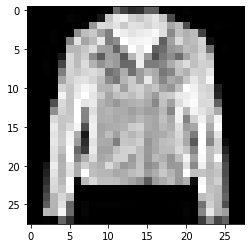

In [ ]:
# train_data의 피처 데이터는 이미지의 각 픽셀을 데이터프레임화 시킨것으로 이미지로 시각화 하기 위해선 데이터를 픽셀화
# 시킬 필요가 있습니다. 이미지의 각 픽셀 값은 28*28=784이기 때문에 데이터도 28샘플의 28특성으로 바꿔주어야 합니다.
# 데이터의 차원을 변환하기 위해 넘파이 배열로 받겠습니다. 또한 피쳐의 0번째와 1번째는 인덱스값으로 2번째 컬럼 데이터
# 부터 가져옵니다.
plt.imshow(np.array(train_data.iloc[23, 2:]) # 23행에 2번째부터 끝까지의 컬럼 데이터를 반환합니다.
           .reshape(28, 28),                 # 데이터의 형태를 x28*y28로 변환합니다.
           cmap='gray')                      # 이미지 출력 색상을 회색으로 지정합니다.
plt.show()                                   # 출력합니다.

#### `4.` 데이터 크기 변환: train_data와 test_data의 크기 변환

In [ ]:
# 데이터의 크기 변환을 위해 특성의 개수를 784개로 조정하면서 동시에 feature와 target 데이터를 분리하겠습니다.
train_feature_data = train_data.copy().drop(['index', 'label'], axis=1)
test_feature_data = test_data.copy().drop(['index'], axis=1)
train_target_data = train_data['label'].copy()

# 분리된 데이터의 크기를 각 이미지의 픽셀에 맞게 28 * 28로 변환합니다.
# 여기서 reshape(-1, 28, 28, 1)은 (batch_size, width, height, channel)을 의미합니다.
# batch_size를 -1로 두면 컬럼의 개수의 따라 행의 개수를 자동으로 조절해줍니다.
# channel을 1로 두는 이유는 fashion MNIST 이미지는 Gray Scale로 1개의 채널만 필요로 하기 때문입니다.
train_feature_data = train_feature_data.values.reshape(-1, 28, 28, 1)
test_feature_data = test_feature_data.values.reshape(-1, 28, 28, 1)

# 변환된 데이터의 크기를 확인합니다.
print('train_feature_data.shape', train_feature_data.shape)
print('test_feature_data.shape', test_feature_data.shape)

train_feature_data.shape (60000, 28, 28, 1)
test_feature_data.shape (10000, 28, 28, 1)


#### `5.` 데이터 분할: training set와  validation set 나누기

In [ ]:
# training set(x_train, y_train)와 validation set(x_test, y_test)를 나눕니다.
x_train, x_valid, y_train, y_valid = train_test_split(train_feature_data,         # 나누고자 하는 feature데이터를 지정합니다.
                                                    train_target_data,          # 나누고자 하는 target데이터를 지정합니다.
                                                    test_size=0.3,              # 전체 데이터의 30%를 validation set로 구성합니다.
                                                    random_state=23,            # seed 값을 지정합니다.
                                                    shuffle=True,               # 데이터를 섞을지 말지 여부를 지정합니다.
                                                    stratify=train_target_data) # target데이터가 한쪽에 편향되지 않게 일정한 비율로 나누어줍니다.

# 나누어진 데이터의 크기를 확인합니다.
print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_valid.shape:', x_valid.shape)
print('y_valid.shape:', y_valid.shape)

x_train.shape: (42000, 28, 28, 1)
y_train.shape: (42000,)
x_valid.shape: (18000, 28, 28, 1)
y_valid.shape: (18000,)


#### `6.` 데이터 전처리: 데이터 정규화

In [ ]:
# 이미지의 각 픽셀값(0 ~ 255)을 0 ~ 1 값으로 정규화 시켜 연산비용을 줄이고 최적의 성능을 유도합니다.
x_train = x_train.astype('float32') / 255
x_valid = x_valid.astype('float32') / 255

# 정규화된 데이터의 최소값과 최대값을 확인합니다.
print('x_train의 최소값: {}, 최대값: {}'.format(np.min(x_train), np.max(x_train)))
print('x_valid의 최소값: {}, 최대값: {}'.format(np.min(x_valid), np.max(x_valid)))

x_train의 최소값: 0.0, 최대값: 1.0
x_valid의 최소값: 0.0, 최대값: 1.0


#### `7.` 모델 구축

In [ ]:
# Sequential 모델을 cnn_model 변수에 할당합니다.
cnn_model = keras.Sequential()

cnn_model.add(Conv2D(filters=64, kernel_size=2, padding='same', input_shape=(28, 28, 1), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.3))

cnn_model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.3))
    
cnn_model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.3))
    
cnn_model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.3))
    
cnn_model.add(Flatten())
cnn_model.add(Dense(1024, activation ='relu'))
cnn_model.add(Dense(512, activation ='relu'))
cnn_model.add(Dense(256, activation ='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(10, activation ='softmax'))
          
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### `8.` 모델 파라미터 정의

In [ ]:
# 모델의 성능이 개선되지 않을 때 자동으로 학습을 종료시켜주는 함수입니다.
es = EarlyStopping(
    monitor='val_accuracy', # 모니터링할 지표를 지정합니다.
    patience=50)            # 성능이 개선되지 않을 때 허용 횟수를 지정합니다. (51번째에도 개선이 없으면 종료)

# 모델이 최적의 성능을 낼 때 자동으로 저장을 해주는 함수입니다.
mc = ModelCheckpoint(
    filepath='./cnn_model_checkpoints/', # 파일을 저장할 경로입니다.
    monitor='val_accuracy',              # 모니터링할 지표를 지정합니다.
    verbose=0,                           # 저장 메세지 출력 여부를 지정합니다. (0: 출력x, 1: 출력 o)
    save_weights_only=True,              # 가중치를 저장할지 여부를 지정합니다.
    save_best_only=True)                 # 이전보다 성능이 좋을 경우에만 저장하도록 합니다.

# 모델의 성능이 향상되지 않는 경우 학습률을 낮추는 함수입니다.
rlrop = ReduceLROnPlateau(
    factor=0.5, # 기준을 만족할때마다 학습률을 얼만큼 감소시킬지 정합니다.
    patience=5, # 개선되지 않는 에포크를 몇 번 허용할지 정합니다. (6번째에도 개선이 없으면 학습률 조정)
    verbose=0)  # 학습률 조정시 메세지 출력 여부를 지정합니다. (0: 출력x, 1: 출력 o)

#### `9.` 모델 학습

In [ ]:
model_history = cnn_model.fit(x_train,                            # 학습할 피쳐 데이터를 지정합니다.
                              y_train,                            # 학습할 타겟 데이터를 지정합니다.
                              epochs=1000,                        # 에포크 횟수를 지정합니다.
                              batch_size=420,                     # 420개씩 학습을 진행합니다.
                              validation_data=(x_valid, y_valid), # 검증 데이터를 지정합니다.
                              callbacks=[es, mc, rlrop])          # 콜백함수를 지정합니다.

Epoch 1/1000
100/100 [==============================] - 10s 40ms/step - loss: 0.9840 - accuracy: 0.6280 - val_loss: 3.2009 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/1000
100/100 [==============================] - 3s 31ms/step - loss: 0.6020 - accuracy: 0.7761 - val_loss: 4.2183 - val_accuracy: 0.1003 - lr: 0.0010
Epoch 3/1000
100/100 [==============================] - 3s 31ms/step - loss: 0.5039 - accuracy: 0.8188 - val_loss: 4.7510 - val_accuracy: 0.1096 - lr: 0.0010
Epoch 4/1000
100/100 [==============================] - 3s 31ms/step - loss: 0.4498 - accuracy: 0.8370 - val_loss: 2.5891 - val_accuracy: 0.2843 - lr: 0.0010
Epoch 5/1000
100/100 [==============================] - 3s 31ms/step - loss: 0.4124 - accuracy: 0.8544 - val_loss: 1.5130 - val_accuracy: 0.5293 - lr: 0.0010
Epoch 6/1000
100/100 [==============================] - 3s 31ms/step - loss: 0.3922 - accuracy: 0.8601 - val_loss: 0.7362 - val_accuracy: 0.7445 - lr: 0.0010
Epoch 7/1000
100/100 [=============================

#### `10.` 모델의 학습 시각화

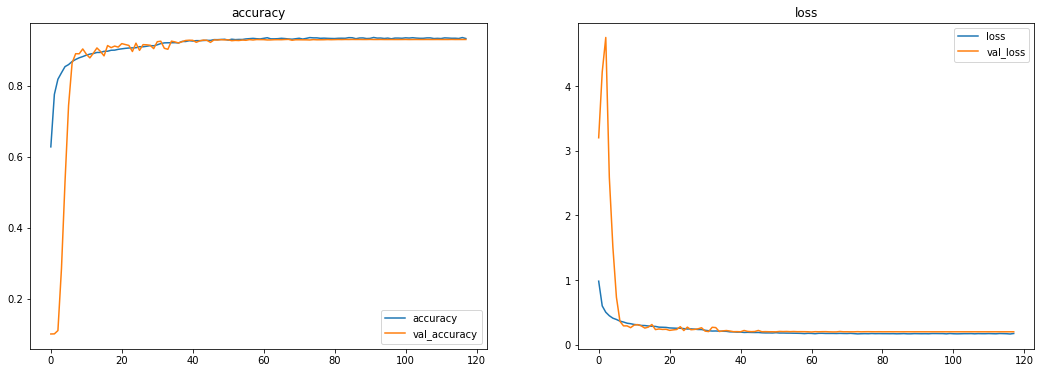

In [ ]:
plt.figure(figsize=(18, 6))

# 에포크별 정확도를 시각화합니다.
plt.subplot(1,2,1)
plt.plot(model_history.history["accuracy"], label="accuracy")
plt.plot(model_history.history["val_accuracy"], label="val_accuracy")
plt.title("accuracy")
plt.legend()

# 에포크별 손실률을 시각화합니다.
plt.subplot(1,2,2)
plt.plot(model_history.history["loss"], label="loss")
plt.plot(model_history.history["val_loss"], label="val_loss")
plt.title("loss")
plt.legend()

plt.show()

#### `11.` 예측 및 제출 양식 저장

#### 사용하지 않는 코드

In [ ]:
# # 딥러닝 모델은 활성화 함수를 지정하여 사용하는데 활성화 함수를 사용하기 위해선 모든 범주형 데이터를 0과 1로
# # 인코딩 처리를 해야합니다. 따라서 범주형 데이터인 target 데이터를 0과 1로 원핫인코딩 하겠습니다.
# y_train = to_categorical(y_train)
# y_valid = to_categorical(y_valid)

# # 원핫인코딩 후 데이터의 크기를 확인합니다.
# print('y_train.shape:', y_train.shape)
# print('y_valid.shape:', y_valid.shape)
###############################################################################